# 2. házi feladat

###**A**: Az adatbázis letöltése

**A/1 - A/6**: A tesztelőszkript a számodra szükséges adatbázist tölti le és a részedre kiosztott feladatok helyességét fogja tesztelni. Ehhez az alábbi kódblokk tetején, a Tester példányosításakor paraméterként a Neptun-kódodat kell megadni egy sztringként, pl: 
`tester = Tester('DK7UAQ')`

**Információ az adatbázisokról**:
Az adatbázisok a UCI Machine Learning Repository-ról származnak.
- **A/1**: Különböző vegyületekre (a vegyületek tulajdonságai alapján) próbáljuk megbecsülni azt a mennyiséget, ami az esetek 50%-ában megöli a _Pimephales promelas_ fajtájú halat. http://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity
- **A/2**: Két portugál középiskolában a tanulók évvégi matematika jegyét (0-20) próbáljuk megbecsülni a tanulók szociális és pénzügyi háttere alapján. http://archive.ics.uci.edu/ml/datasets/Student+Performance 
- **A/3**: Lásd A/2, matematika helyett portugál nyelv tárgyból.
- **A/4**: Lásd A/2. Az A/2. és A/3.-ban használt adatbázisok esetében az input változók közt megtalálhatók a tanulók első- és második harmadévvégi osztályzata az adott tárgyból. Ezekkel nyilvánvalóan erősen korrelál az év végi jegy, így nehezíti a feladatot, ha ezeket az input változókat elhagyjuk. Az A/4 és A/5. adatbázisaiból ezek a változók hiányoznak, így jelentősen gyengébb eredmény várható.
- **A/5**: Lásd A/4, matematika helyett portugál nyelv tárgyból.
- **A/6**: Betontömbök nyomószilárdságát (~1-100 MPa) próbáljuk megbecsülni a betontömbök összetevőinek mennyiségéből, előállítási körülményeikből és korukból. http://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength

A tesztelőszkript letölti a szöveges formában tárolt adatbázist és elhelyezi a `content` sztringben. Alább, kiírjuk a hosszát és az első 500 karaktert is a sztringből. Az adatbázis fájlok egy-egy sora adja meg az egy-egy mintaelemhez tartozó adatokat, ahol az utolsó érték a címke, míg a többi érték az input változók értékeit kódolja. Az adatbázis első sora a változók neveit tartalmazza.

A feladatod, hogy alakítsd át a `content` sztringet az adatbázis input változóit és címkéit tartalmazó tömbbé. A tömbök típusa np.float32 (lebegőpontos) típusú legyen! Az input változók értékeit helyezd el a `features` (n_mintaelem, n_valtozo) alakú tömbben, míg a címkéket a `labels` (n_mintaelem,) alakú tömbben!



In [3]:
# implement your solution BELOW

lines = content.split("\n")
words = [line.split(";") for line in lines[1:-1]]    # ignore attribute names and last (empty) line

vals = [[float(item) for item in rec] for rec in words]
vals = np.array(vals, dtype=np.float32)

splitted = np.hsplit(vals, (vals.shape[1] - 1,))
features, labels = splitted[0], splitted[1].flatten()

# implement your solution ABOVE

Tester: Dataset preparation OK


## **B**: Tanító-, validációs- és teszthalmaz szétválasztása

Keverd meg véletlenszerűen a mintaelemeket a `features` és `labels` tömbökben (természetesen a két tömb permutálása legyen azonos)! Ez azért szükséges, mert az adatbázisban az elemek lehet, hogy rendezettek pl. a címkék szerint. Megkeverés nélkül, a szétválasztott halmazokban jelentősen különbözne a címkék eloszlása. 

Ezt követően válaszd szét a tömböket tanító-, validációs- és teszthalmazra!

A szétválasztás történjen az alábbi arányokkal:
- **B/1**.: 70% / 15% / 15%
- **B/2**: 60% / 20% / 20%
- **B/3**: 50% / 25% / 25%

A halmazokat tartalmazó három-három input- és címketömb változókat nevezd el `x_unnorm_train`, `x_unnorm_val`, `x_unnorm_test`, `y_train`, `y_val`, `y_test`-nek sorrendben.

In [4]:
# implement your solution BELOW

# shuffle rows
p = np.random.permutation(len(labels))
features, labels = features[p], labels[p]

# distribute elements
n_samp = len(features)
distr = (0.5, .25, .25)

distr = tuple(np.add.accumulate(np.array(distr) * n_samp, dtype=np.int32) + 1)
distr = np.insert(distr, 0, 0)  # indexing start at 0
ind1, ind2, ind3 = (np.s_[distr[i]:distr[i+1]] for i in range(len(distr) - 1))  # ngrams

x_unnorm_train, y_train = features[ind1], labels[ind1]

x_unnorm_val, y_val = features[ind2], labels[ind2]

x_unnorm_test, y_test = features[ind3], labels[ind3]

# implement your solution ABOVE

Tester: Dataset split OK


## **C**: Az input változók azonos nagyságrendre hozása

A változók azonos nagyságrendre hozása az alábbi technikával történjen:
- **C/1**: sztenderdizáció (0 átlag, 1 szórás)
- **C/2**: min-max skálázás (0 minimum, 1 maximum)

A változókat egymástól függetlenül kell skálázni. A skálázáshoz szükséges átlagot és szórást / minimumot és maximumot a tanítóhalmazon számold ki, majd alkalmazd őket a validációs és a teszt halmazra. Ez azért szükséges, mert a teszthalmazról azt feltételezzük, hogy ismeretlen a betanítás során, pontosan azért, hogy semmi esetre se tudjuk hozzáigazítani a tanított modellünket. 

**A feladatot *NumPy* segítségével kell megoldani. Ennek a részfeladatnak a megoldásához nem megengedett a *Keras* és a *TensorFlow* könyvtárnak és azok almoduljainak használata.**

A skálázott halmazokat tartalmazó három változót nevezd el `x_train`, `x_val`, `x_test`-nek sorrendben!

In [20]:
# implement your solution BELOW

per_feature_min = x_unnorm_train.min(axis=0)
per_feature_max = x_unnorm_train.max(axis=0)
per_feature_diff = (per_feature_max - per_feature_min)

x_train = (x_unnorm_train - per_feature_min) / per_feature_diff

x_val = (x_unnorm_val - per_feature_min) / per_feature_diff

x_test = (x_unnorm_test - per_feature_min) / per_feature_diff

# implement your solution ABOVE

(32,)
Tester: Feature rescale OK


## **D**: A regressziós neuronháló definiálása Keras-ban 

Használd a `keras.models.Sequential()` osztályt a háló definiálásához! A háló architektúráját az alábbiak alapján alakítsd ki:
- **D/1**: Kétrétegű háló, az első réteg neuronjainak száma 50, aktivációs függvénye ReLU. Az első réteg után alkalmazz dropout-ot neurononként 30%-os valószínűséggel!
- **D/2**: Négyrétegű háló, a neuronok száma rendre 20, 20, 10, aktivációs függvényük ReLU. Az egyes rétegek közé tégy dropout rétegeket, melyek 20%-os valószínűséggel nulláznak ki egy-egy elemet!
- **D/3**: Háromrétegű háló, a neuronok száma rendre 50, 30. Aktivációs függvényként használj sorban tanh-t, majd ReLU-t!

Minden esetben csak teljesen összekötött (dense) rétegeket, valamint dropout rétegeket kell használnod. Az aktivációs függvényeket a teljesen összekötött rétegek `activation` paramétereként add meg (azaz most ne használj külön Acitvation rétegeket). A rétegek számába beleértendő a kimenetre képző, utolsó réteg is, melynek méretét a címke mérete határozza meg. Alkalmazd a tanult aktivációs függvényt az utolsó rétegen, függően a feladat típusától.
A modellt fordítsd le a `compile()` függvény segítségével: a költségfüggvény legyen a szokásos, regresszióhoz használatos átlagos négyzetes eltérés (MSE), optimizer algoritmusként pedig alkalmazd az SGD algoritmust megfelelő tanulási rátával! 
A regressziós neuronhálót tartalmazó keras.models.Sequential() típusú változót nevezd el `reg_model`-nek!

In [243]:
# implement your solution BELOW

reg_model = tf.keras.models.Sequential()
reg_model.add(tf.keras.layers.Dense(50, activation="tanh", input_dim=x_train.shape[1]))
reg_model.add(tf.keras.layers.Dense(30, activation="relu"))
reg_model.add(tf.keras.layers.Dense(1))

reg_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                  loss="mse",
                  metrics=[tf.keras.metrics.mean_absolute_error])

# implement your solution ABOVE

Tester: Regression model architecture OK


## **E**: A háló betanítása regressziós feladatra

Tanítsd be a neuronhálót a tanítóhalmazon! Használj early stopping-ot a validációs halmazzal! A tanulási rátát, epoch-ok maximális számát, a batch méretet, az early stopping `patience` paraméterét szabadon átállíthatod. Próbálgathatsz különböző kombinációkat, hogy jobb eredményt érj el.

- Rajzold ki, hogyan alakult a tanulási és validációs költség a betanítás során! Ehhez használhatod a `matplotlib` könyvtárat, példát találsz a 8. előadás notebookjában. 
- A négyzetes (MSE) költség mellett az átlagos abszolút hiba (Mean Absolute Error, MAE) tanító- és validációs halmazon történő alakulását is rajzold ki egy másik grafikonon! A grafikonok y tengelyének megjelenített értékhatárait úgy állítsd be, hogy mindegyik idősor látható legyen és könnyen ki lehessen venni a költségek alakulását a tanítás vége felé is!
- Számold ki a betanított modell négyzetes hibáját és az átlagos abszolút hibát a teszthalamzon, majd add értékül ezeket az értékeket a `test_mse` és `test_mae` változóknak!
- Válassz néhány példát a teszthalmazból és becsülj hozzájuk címkét a betanított modellel, majd írasd ki a becsült és a megfelelő helyes címkéket! Így példákon is láthatjuk, hogy mennyire ad jó becsléseket a neuronhálónk.



Epoch 1/600
21/21 [==============================] - 1s 11ms/step - loss: 57.2709 - mean_absolute_error: 6.3320 - val_loss: 9.9752 - val_mean_absolute_error: 2.3681
Epoch 2/600
21/21 [==============================] - 0s 4ms/step - loss: 9.9567 - mean_absolute_error: 2.3402 - val_loss: 7.8427 - val_mean_absolute_error: 1.9933
Epoch 3/600
21/21 [==============================] - 0s 4ms/step - loss: 9.1288 - mean_absolute_error: 2.2160 - val_loss: 7.4824 - val_mean_absolute_error: 1.9376
Epoch 4/600
21/21 [==============================] - 0s 3ms/step - loss: 8.4297 - mean_absolute_error: 2.1157 - val_loss: 7.0830 - val_mean_absolute_error: 1.8691
Epoch 5/600
21/21 [==============================] - 0s 3ms/step - loss: 7.8401 - mean_absolute_error: 2.0117 - val_loss: 6.5122 - val_mean_absolute_error: 1.7861
Epoch 6/600
21/21 [==============================] - 0s 4ms/step - loss: 7.1874 - mean_absolute_error: 1.9352 - val_loss: 5.9271 - val_mean_absolute_error: 1.6862
Epoch 7/600
21/21 [=

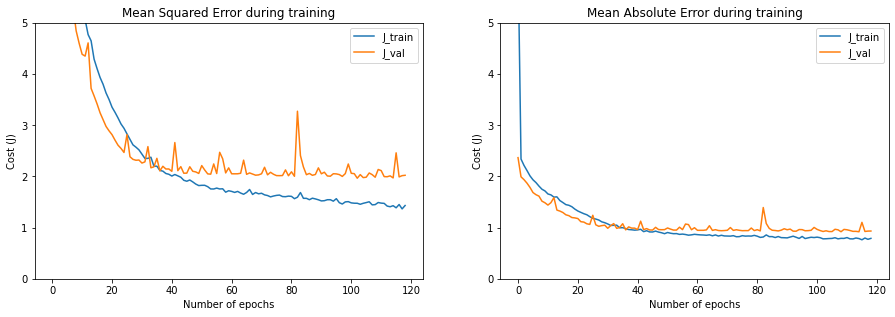

In [244]:
# implement your solution BELOW

# training
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=16)

history = reg_model.fit(x_train, y_train, validation_data=(x_val, y_val),
              batch_size=16, epochs=600, verbose=1, callbacks=[earlystopping_callback])

# metrics visualization
tr_mse_losses = history.history['loss']
val_mse_losses = history.history['val_loss']
tr_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

# plots
plt.figure(figsize=(32, 16))

plt.subplot(3, 4, 1)
plt.plot(tr_mse_losses, label="J_train")
plt.plot(val_mse_losses, label="J_val")
plt.ylim((0,5))
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.legend()
plt.title("Mean Squared Error during training")

plt.subplot(3, 4, 2)
plt.plot(tr_mae, label="J_train")
plt.plot(val_mae, label="J_val")
plt.ylim((0,5))
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.legend()
plt.title("Mean Absolute Error during training")

# metrics
test_mse, test_mae = reg_model.evaluate(x_test, y_test)


# testing for a few, random values
samp_size = 10
rand_idxs = np.random.randint(len(x_test), size=samp_size)
predictions = reg_model.predict(x_test[rand_idxs].reshape(samp_size,-1)).flatten()
ground_t_labels = y_test[rand_idxs]

print("Pred. | Truth | Abs. err.")
for (p, g) in zip(predictions, ground_t_labels):
  print(f"{p:4.1f}  |  {g:4.1f} | {abs(p - g):4.1f}")

# implement your solution ABOVE

## **F**: A regressziós adatbázis átalakítása klasszifikációs adatbázissá

Alakítsd át a regressziós adatbázist, hogy alkalmas legyen 
klasszifikációs feladathoz! A kategóriákat az alábbiak alapján alakítsd ki : 

*   **F/1**: 3 kategória. A kategóriákat úgy alakítsd ki, hogy a regressziós adatbázis címkéinek intervallumán felveszel két küszöbértéket. Az első kategóriába a kisebb küszöbérték alatti, a másodikba a két küszöbérték közti és a harmadikba a nagyobb küszöbérték feletti címkével rendelkező mintaelemek kerüljenek. 
Tehát, például ha a regressziós adatbázis címkéi 3 és 8 közt vannak, akkor a két küszöbértéknek választhatjuk az 5.2-t és a 6.1-et. Ekkor az 1. kategóriába az 5.2-nél kisebb címkéjű elemek, a 2. kategóriába az 5.2 és 6.1 közti címkéjű elemek és a 3. kategóriába a 6.1-nél nagyobb címkéjű elemek kerülnek. Azonos címkéjű elemek mindenképpen azonos kategóriába kell, hogy kerüljenek.

*   **F/2**: 4 kategória. A kategóriákat úgy alakítsd ki, hogy a regressziós adatbázis címkéinek intervallumán felveszel három küszöbértéket. Az első kategóriába a kisebb küszöbérték alatti, a másodikba az első és második küszöbérték közti, a harmadikba a második és a haramdik küszöbérték közti, és a negyedikbe a harmadik küszöbérték feletti címkével rendelkező mintaelemek kerüljenek. 
Tehát, például ha a regressziós adatbázis címkéi 3 és 8 közt vannak, akkor a három küszöbértéknek választhatjuk a 3.8-at, a 6.1-et és a 7.5-öt. Ekkor az 1. kategóriába az 3.8-nál kisebb címkéjű elemek, a 2. kategóriába az 3.8 és 6.1 közti címkéjű elemek, a 3. kategóriába az 6.1 és 7.5 közti címkéjű elemek és a 4. kategóriába a 7.5-nél nagyobb címkéjű elemek kerülnek. Azonos címkéjű elemek mindenképpen azonos kategóriába kell, hogy kerüljenek.


Válaszd ki a küszöbértékeket úgy, hogy a kategóriábákba **megközelítőleg** ugyanannyi elem kerüljön! Hozd létre az új kategóriacímkéket az `y_train`, `y_val`, `y_test` tömbökből. Kerüljenek ezek a `y_cat_train`, `y_cat_val`, `y_cat_test` változókba!



In [245]:
# implement your solution BELOW

cat_count = 3
ideal_group_size = len(y_train) / cat_count
ideal_group_counts = ideal_group_size * np.arange(1,cat_count)

uniqes, counts = np.unique(y_train, return_counts=True)

# lowest difference from ideal divison point
div_idx = np.argmin(np.absolute(np.add.accumulate(counts) - ideal_group_counts[:,None]), axis=1)

# matrix to compare which category a value falls into
div_vals = uniqes[div_idx]
div_vals_lower = np.insert(div_vals, 0, 0)
div_vals_upper = np.append(div_vals, uniqes[-1])

# used to categorize every value, based on the divison points
# calculated from the 'train' dataset (y_train)
def categorize(mx): return np.argmax( (div_vals_lower[:,None] < mx) &
                                      (mx <= div_vals_upper[:,None]),
                                    axis=0 )

# categorize
to_categorize = (y_train, y_val, y_test)
y_cat_train, y_cat_val, y_cat_test = (categorize(mx) for mx in to_categorize)

# implement your solution ABOVE

Tester: Classification dataset creation OK


## **G**: Kategóriacímkék átalakítása one-hot kódolásra

Kettőnél több kategóriás (multi-class) klasszifikációnál minden kategóriához egy valószínűséget becslünk, azaz a háló kimenete akkora méretű, ahány kategóriánk van. Így tehát az igazi címkéink ugyanekkora méretű one-hot kódolású vektorok lesznek, ezeket címkevektorokként használva fogjuk betanítani a hálót.

Készítsd el a one-hot kódolású címkevektor tömböket a kategóriacímkéket tartalmazó `y_cat_train`, `y_cat_val`, `y_cat_test` tömbökből! Az új tömbök kerüljenek a `y_onehot_train`, `y_onehot_val`, `y_onehot_test` változókba! A tömbök alakja így (n_samples, n_categories), típusuk legyen `np.float32`!


In [246]:
# implement your solution BELOW

from keras.utils.np_utils import to_categorical   

# encode
to_encode = (y_cat_train, y_cat_val, y_cat_test)
y_onehot_train, y_onehot_val, y_onehot_test = (to_categorical(mx, cat_count) for mx in to_encode)

# implement your solution ABOVE

Tester: One-hot conversion OK


## **H**: A klasszifikációs neuronháló definiálása Keras-ban 

Használd a `keras.models.Sequential()` osztályt a háló definiálásához! A háló architektúráját az alábbiak alapján alakítsd ki:
- **H/1**: Kétrétegű háló, az első réteg neuronjainak száma 50, aktivációs függvénye ReLU. Az első réteg után alkalmazz dropout-ot neurononként 30%-os valószínűséggel!
- **H/2**: Négyrétegű háló, a neuronok száma rendre 20, 20, 10, aktivációs függvényük ReLU. Az egyes rétegek közé tégy dropout rétegeket, melyek 20%-os valószínűséggel nulláznak ki egy-egy elemet!
- **H/3**: Háromrétegű háló, a neuronok száma rendre 50, 30. Aktivációs függvényként használj sorban tanh-t, majd ReLU-t!

Minden esetben csak teljesen összekötött (dense) rétegeket, valamint dropout rétegeket kell használnod. Az aktivációs függvényeket a telejesen összekötött rétegek `activation` paramétereként add meg (azaz most ne használj külön Acitvation rétegeket). A rétegek számába beleértendő a kimenetre képző, utolsó réteg is, melynek méretét a címke mérete határozza meg. Alkalmazd a tanult aktivációs függvényt az utolsó rétegen, függően a feladat típusától!
A modellt fordítsd le a `compile()` függvény segítségével: a költségfüggvény legyen a szokásos, multi-class klasszifikációhoz használatos (categorical) crossentropy, optimizer algoritmusként pedig alkalmazd az SGD algoritmust megfelelő tanulási rátával! 
A klasszifikációs neuronhálót tartalmazó keras.models.Sequential() típusú változót nevezd el `cl_model`-nek. 

In [355]:
# implement your solution BELOW

cl_model = tf.keras.models.Sequential()
cl_model.add(tf.keras.layers.Dense(50, activation="tanh", input_dim=x_train.shape[1]))
cl_model.add(tf.keras.layers.Dense(30, activation="relu"))
cl_model.add(tf.keras.layers.Dense(cat_count, activation="softmax"))

cl_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.008),
                 loss="categorical_crossentropy",
                 metrics=[tf.keras.metrics.CategoricalAccuracy()])

# implement your solution ABOVE

Tester: Classification model architecture OK


## **I**: A háló betanítása (multi-class) klasszifikációs feladatra

Tanítsd be a neuronhálót a tanítóhalmazon! Használj early stopping-ot a validációs halmazzal! A tanulási rátát, epoch-ok maximális számát, a batch méretet, az early stopping `patience` paraméterét szabadon átállíthatod. Próbálgathatsz különböző kombinációkat, hogy jobb eredményt érj el.

- Rajzold ki, hogyan alakult a tanulási és validációs költség a betanítás során! Ehhez használhatod a `matplotlib` könyvtárat, példát találsz a 8. előadás notebookjában. 
- A crossentropy költség mellett, a helyesen klasszifikált mintaelemek arányának (_accuracy_) tanító- és validációs halmazon történő alakulását is rajzold ki egy másik grafikonon! A grafikonok y tengelyének megjelenített értékhatárait úgy állítsd be, hogy mindegyik idősor látható legyen és könnyen ki lehessen venni a költségek alakulását a tanítás vége felé is!
- Számold ki a betanított modell crossentropy költségét és az accuracy metrikát a teszthalamzon, majd add értékül ezeket az értékeket a `test_ce` és `test_acc` változóknak!
- Számold ki a multiclass _Fals pozitív arány_ (FPR) és _Fals negatív arány_ (FNR) metrikákat a teszthalmazon a betanított modelledre, majd add értékül ezeket az értékeket a `test_fpr` és `test_fnr` változóknak! Az FPR és FNR kiszámításához az első házi feladat B/1. és B/2. feladataiban található képletek és leírás segíthetnek. A **saját**, 1. házi feladatban beadott FPR vagy FNR metrikát kiszámító kódodat természetesen felhasználhatod itt is.

Epoch 1/600
21/21 [==============================] - 1s 11ms/step - loss: 1.1121 - categorical_accuracy: 0.3508 - val_loss: 1.0756 - val_categorical_accuracy: 0.4321
Epoch 2/600
21/21 [==============================] - 0s 4ms/step - loss: 1.0997 - categorical_accuracy: 0.3662 - val_loss: 1.0678 - val_categorical_accuracy: 0.4321
Epoch 3/600
21/21 [==============================] - 0s 4ms/step - loss: 1.0880 - categorical_accuracy: 0.3754 - val_loss: 1.0572 - val_categorical_accuracy: 0.4506
Epoch 4/600
21/21 [==============================] - 0s 3ms/step - loss: 1.0782 - categorical_accuracy: 0.3938 - val_loss: 1.0557 - val_categorical_accuracy: 0.4630
Epoch 5/600
21/21 [==============================] - 0s 4ms/step - loss: 1.0681 - categorical_accuracy: 0.4031 - val_loss: 1.0452 - val_categorical_accuracy: 0.4753
Epoch 6/600
21/21 [==============================] - 0s 4ms/step - loss: 1.0580 - categorical_accuracy: 0.4246 - val_loss: 1.0416 - val_categorical_accuracy: 0.5062
Epoch 7/6

AssertionError: ignored

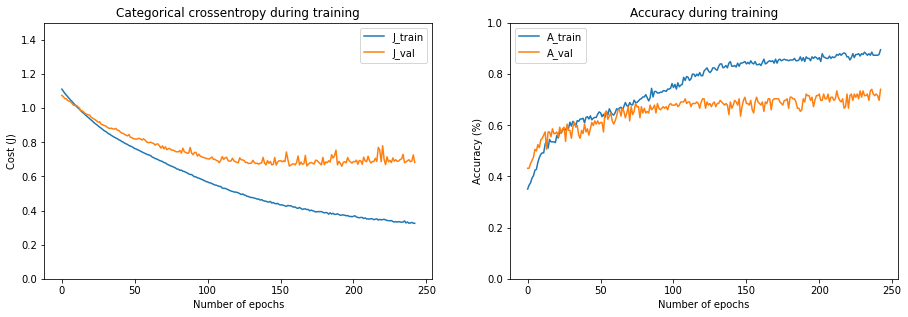

In [356]:
# implement your solution BELOW

def multiclass_fpr_fnr(y_onehot_pred, y_onehot_true):
    pred_classes = np.argmax(y_onehot_pred, axis=1)
    class_cnt = y_onehot_pred.shape[1]
    y_true = np.argmax(y_onehot_test, axis=1)  # reverse one-hot

    # https://www.mdpi.com/2227-7080/9/4/81/htm
    confusion_mx = np.bincount(y_true * class_cnt + pred_classes,
                               minlength=class_cnt*class_cnt)\
                     .reshape((class_cnt, class_cnt))

    per_class_true_pos = np.diagonal(confusion_mx)

    per_class_true_pos_plus_false_pos = np.sum(confusion_mx, axis=0)
    per_class_false_pos = per_class_true_pos_plus_false_pos - per_class_true_pos

    per_class_true_pos_plus_false_neg = np.sum(confusion_mx, axis=1)
    per_class_false_neg = per_class_true_pos_plus_false_neg - per_class_true_pos

    per_class_true_neg = np.sum(confusion_mx) - \
                         (per_class_true_pos_plus_false_pos + per_class_false_neg)

    # to avoid warning when dividing with 0 in case of 0/0
    summed_fpr = np.sum(np.divide(per_class_false_pos,
                                  per_class_false_pos + per_class_true_neg,
                                  out=np.zeros(per_class_false_pos.shape),
                                  where=per_class_true_pos_plus_false_pos!=0))
        
    summed_fnr = np.sum(np.divide(per_class_false_neg,
                                  per_class_true_pos_plus_false_neg,
                                  out=np.zeros(per_class_false_neg.shape),
                                  where=per_class_true_pos_plus_false_neg!=0))

    return (summed_fpr / class_cnt), (summed_fnr / class_cnt)

# training
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)

history = cl_model.fit(x_train, y_onehot_train, validation_data=(x_val, y_onehot_val),
                       batch_size=16, epochs=600, verbose=1, callbacks=[earlystopping_callback])

# metrics visualization
tr_mse_losses = history.history['loss']
val_mse_losses = history.history['val_loss']
tr_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

# plots
plt.figure(figsize=(32, 16))

plt.subplot(3, 4, 1)
plt.plot(tr_mse_losses, label="J_train")
plt.plot(val_mse_losses, label="J_val")
plt.ylim((0,1.5))
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.legend()
plt.title("Categorical crossentropy during training")

plt.subplot(3, 4, 2)
plt.plot(tr_acc, label="A_train")
plt.plot(val_acc, label="A_val")
plt.ylim((0,1))
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy during training")

# metrics
test_ce, test_acc = cl_model.evaluate(x_test, y_onehot_test)

test_fpr, test_fnr = multiclass_fpr_fnr(cl_model.predict(x_test), y_onehot_test)

print(test_fpr)
print(test_fnr)
print(test_ce)
print(test_acc)

# implement your solution ABOVE